In [15]:
from argparse import ArgumentParser
from os import path
from pprint import pprint

import cv2
import hdf5storage
import numpy as np
from tqdm import tqdm
from pts_tools import expand_box, fit_box
import matplotlib.pyplot as plt
import os

In [16]:
os.chdir('../')

In [17]:
def load_labels(label_file, is_train):
    out = hdf5storage.loadmat(label_file)
    samples = []
    if is_train:
        record = out['label_train'][0]
        for item in record:
            samples.append(
                {
                    'image_file': item[1][0],
                    'labels': [v for v in item[2].astype(int)]
                }
            )
    else:
        record = out['LabelTest'][0]
        for item in record:
            samples.append(
                {
                    'image_file': item[0][0],
                    'labels': [v for v in item[1].astype(int)]
                }
            )
    return samples

In [19]:
# load data from training set
samples = load_labels('data/MAFA/LabelTrainAll.mat', True)

In [21]:
def parse_labels(raw_labels, is_train=True):
    """
    FOR TRAIN LABELS
        raw labels form: [x,y,w,h, x1,y1,x2,y2, x3,y3,w3,h3, occ_type, occ_degree,
        gender, race, orientation, x4,y4,w4,h4]
        (a) (x,y,w,h) is the bounding box of a face,
        (b) (x1,y1,x2,y2) is the position of two eyes.
        (c) (x3,y3,w3,h3) is the bounding box of the occluder. Note that (x3,y3)
            is related to the face bounding box position (x,y)
        (d) occ_type stands for the occluder type and has: 1 for simple, 2 for
            complex and 3 for human body.
        (e) occ_degree stands for the number of occluded face parts
        (f) gender and race stand for the gender and race of one face
        (g) orientation stands for the face orientation/pose, and has: 1-left,
            2-left frontal, 3-frontal, 4-right frontal, 5-right
        (h) (x4,y4,w4,h4) is the bounding box of the glasses and is set to
            (-1,-1,-1,-1) when no glasses. Note that (x4,y4) is related to the
            face bounding box position (x,y)

    FOR TEST LABELS
        The format is stored in a 18d array (x,y,w,h,face_type,x1,y1,w1,h1, occ_type,
        occ_degree, gender, race, orientation, x2,y2,w2,h2), where
        (a) (x,y,w,h) is the bounding box of a face, 
        (b) face_type stands for the face type and has: 1 for masked face, 2 for
            unmasked face and 3 for invalid face.
        (c) (x1,y1,w1,h1) is the bounding box of the occluder. Note that (x1,y1)
            is related to the face bounding box position (x,y)
        (d) occ_type stands for the occluder type and has: 1 for simple, 2 for 
            complex and 3 for human body.
        (e) occ_degree stands for the number of occluded face parts
        (f) gender and race stand for the gender and race of one face
        (g) orientation stands for the face orientation/pose, and has: 1-left, 
            2-left frontal, 3-frontal, 4-right frontal, 5-right
        (h) (x2,y2,w2,h2) is the bounding box of the glasses and is set to 
            (-1,-1,-1,-1) when no glasses.  Note that (x2,y2) is related to the 
            face bounding box position (x,y)

    """
    labels = []
    if is_train:
        for raw_label in raw_labels:
            labels.append(
                {
                    'face': [raw_label[0], raw_label[1], raw_label[2], raw_label[3]],
                    'eyes': [raw_label[4], raw_label[5], raw_label[6], raw_label[7]],
                    'occlude': {
                        'location': [raw_label[8], raw_label[9], raw_label[10], raw_label[11]],
                        'type': raw_label[12],
                        'degree': raw_label[13]},
                    'gender': raw_label[14],
                    'race': raw_label[15],
                    'orientation': raw_label[16],
                    'glass': [raw_label[17], raw_label[18], raw_label[19], raw_label[20]]
                }
            )
    else:
        for raw_label in raw_labels:
            labels.append(
                {
                    'face': [raw_label[0], raw_label[1], raw_label[2], raw_label[3]],
                    'face_type': raw_label[4],
                    'occlude': {
                        'location': [raw_label[5], raw_label[6], raw_label[7], raw_label[8]],
                        'type': raw_label[9],
                        'degree': raw_label[10]},
                    'gender': raw_label[11],
                    'race': raw_label[12],
                    'orientation': raw_label[13],
                    'glass': [raw_label[14], raw_label[15], raw_label[16], raw_label[17]]
                }
            )

    return labels

In [9]:
samples[0]

{'image_file': 'train_00000001.jpg',
 'lables': [array([ 95, 160,  91,  91, 113, 177, 158, 172,   7,  26,  82,  89,   1,
           3,   1,   1,   3,  -1,  -1,  -1,  -1])]}

In [22]:
labels = parse_labels(samples[0]['labels'])

In [23]:
# load the parsed labels in sample 1
labels

[{'eyes': [113, 177, 158, 172],
  'face': [95, 160, 91, 91],
  'gender': 1,
  'glass': [-1, -1, -1, -1],
  'occlude': {'degree': 3, 'location': [7, 26, 82, 89], 'type': 1},
  'orientation': 3,
  'race': 1}]

In [5]:
def draw_face(image, labels, color=(0, 255, 0)):
    for label in labels:
        x, y, w, h = label['face']


def draw_mask(image, labels, color=(0, 0, 255)):
    for label in labels:
        x, y, w, h = label['face']
        _x, _y, _w, _h = label['occlude']['location']


def export_face(image, labels, export_file, occ_types=[1, 2, 3], min_size=120, export_size=112):
    """
    Export face areas in an image.
    Args:
        image: the image as a numpy array.
        labels: MAFA labels.
        export_file: the output file name. If more than one face exported, a subfix 
            number will be appended to the file name.
        occ_types: a list of occlusion type which should be exported.
        min_size: the minimal size of faces should be exported.
        exprot_size: the output size of the square image.
    Returns:
        the exported image, or None.
    """
    # Crop the face
    idx_for_face = 0
    image_faces = []
    for label in labels:
        # Not all faces in label is occluded. Filter the image by occlusion,
        # size, etc.
        x, y, w, h = label['face']
        if w < min_size or h < min_size:
            continue

        if label['occlude']['type'] not in occ_types:
            continue

        # Enlarge the face area and make it a square.
        box = expand_box([x, y, x+w, y+h], 1.3)
        box = fit_box(box, image, [(box[0], box[1]), (box[2], box[3])])
        if box is not None:
            image_face = image[box[1]:box[3], box[0]:box[2]]
        else:
            log_file.write(export_file + "\n")
            return None

        # Resize and save image.
        image_face = cv2.resize(image_face, (export_size, export_size))
        new_file = export_file.rstrip(
            '.jpg') + '-{}.jpg'.format(idx_for_face)
        cv2.imwrite(new_file, image_face)
        image_faces.append(image_face)

        idx_for_face += 1

    return image_faces

In [23]:
img_dir = 'train images/'
image_url = path.join(img_dir, samples[0]['image_file'])
image = cv2.imread(image_url)

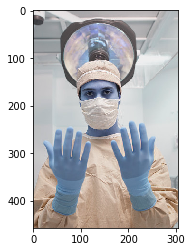

In [24]:
plt.imshow(image)

In [11]:
images = []
total_count = 0
count_bare_face = 0
small_face = 0
bare_face_image = []
bare_face_occ = []
width = []
height = []
img_dir = 'train images/'
for sample in tqdm(samples):
    image_url = path.join(img_dir, sample['image_file'])
    image = cv2.imread(image_url)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    labels = parse_labels(sample['labels']) 
    for label in labels:
        x, y, w, h = label['face']
        width.append(w)
        height.append(h)
        if w < 30 or h <30:
            small_face += 1
        if label['occlude']['type'] not in [1,2,3]:
            count_bare_face += 1
            bare_face_image.append(image)
            bare_face_occ.append(label['occlude']['type'])
    total_count += 1




  0%|          | 0/25876 [00:00<?, ?it/s]

  0%|          | 38/25876 [00:00<01:08, 375.56it/s]

  0%|          | 95/25876 [00:00<01:01, 416.93it/s]

  1%|          | 140/25876 [00:00<01:00, 425.55it/s]

  1%|          | 195/25876 [00:00<00:56, 455.71it/s]

  1%|          | 250/25876 [00:00<00:53, 478.86it/s]

  1%|          | 304/25876 [00:00<00:51, 494.94it/s]

  1%|▏         | 360/25876 [00:00<00:49, 511.86it/s]

  2%|▏         | 416/25876 [00:00<00:48, 523.81it/s]

  2%|▏         | 475/25876 [00:00<00:46, 540.89it/s]

  2%|▏         | 534/25876 [00:01<00:45, 551.72it/s]

  2%|▏         | 589/25876 [00:01<00:46, 540.85it/s]

  2%|▏         | 643/25876 [00:01<00:47, 533.17it/s]

  3%|▎         | 699/25876 [00:01<00:46, 539.70it/s]

  3%|▎         | 761/25876 [00:01<00:44, 560.66it/s]

  3%|▎         | 830/25876 [00:01<00:42, 593.87it/s]

  3%|▎         | 890/25876 [00:01<00:42, 594.85it/s]

  4%|▎         | 950/25876 [00:01<01:02, 399.15it/s]

  4%|▍         | 999/25876 [00:02<01:29

 23%|██▎       | 5825/25876 [00:43<01:28, 227.83it/s]

 23%|██▎       | 5853/25876 [00:43<01:23, 239.62it/s]

 23%|██▎       | 5878/25876 [00:43<01:26, 231.39it/s]

 23%|██▎       | 5907/25876 [00:43<01:21, 245.73it/s]

 23%|██▎       | 5936/25876 [00:43<01:17, 255.76it/s]

 23%|██▎       | 5965/25876 [00:43<01:16, 260.16it/s]

 23%|██▎       | 5992/25876 [00:43<01:15, 261.69it/s]

 23%|██▎       | 6019/25876 [00:43<01:16, 259.07it/s]

 23%|██▎       | 6046/25876 [00:44<01:17, 256.70it/s]

 23%|██▎       | 6072/25876 [00:44<01:17, 255.53it/s]

 24%|██▎       | 6103/25876 [00:44<01:13, 268.20it/s]

 24%|██▎       | 6132/25876 [00:44<01:12, 271.47it/s]

 24%|██▍       | 6160/25876 [00:44<01:13, 267.75it/s]

 24%|██▍       | 6192/25876 [00:44<01:10, 280.97it/s]

 24%|██▍       | 6223/25876 [00:44<01:08, 288.69it/s]

 24%|██▍       | 6253/25876 [00:44<01:07, 289.20it/s]

 24%|██▍       | 6284/25876 [00:44<01:06, 293.38it/s]

 24%|██▍       | 6316/25876 [00:45<01:05, 298.88it/s]

 25%|██▍  

 53%|█████▎    | 13641/25876 [01:18<01:15, 162.82it/s]

 53%|█████▎    | 13662/25876 [01:18<01:11, 170.50it/s]

 53%|█████▎    | 13680/25876 [01:18<01:11, 170.56it/s]

 53%|█████▎    | 13698/25876 [01:18<01:12, 168.18it/s]

 53%|█████▎    | 13724/25876 [01:18<01:04, 188.07it/s]

 53%|█████▎    | 13744/25876 [01:18<01:03, 190.57it/s]

 53%|█████▎    | 13770/25876 [01:18<00:58, 206.93it/s]

 53%|█████▎    | 13792/25876 [01:18<01:03, 190.34it/s]

 53%|█████▎    | 13812/25876 [01:19<01:03, 188.61it/s]

 53%|█████▎    | 13835/25876 [01:19<01:01, 196.14it/s]

 54%|█████▎    | 13856/25876 [01:19<01:03, 189.10it/s]

 54%|█████▎    | 13876/25876 [01:19<01:04, 187.48it/s]

 54%|█████▎    | 13896/25876 [01:19<01:05, 182.36it/s]

 54%|█████▍    | 13917/25876 [01:19<01:03, 189.80it/s]

 54%|█████▍    | 13941/25876 [01:19<01:01, 194.56it/s]

 54%|█████▍    | 13961/25876 [01:19<01:04, 185.46it/s]

 54%|█████▍    | 13981/25876 [01:19<01:03, 187.96it/s]

 54%|█████▍    | 14003/25876 [01:20<01:01, 192.8

 73%|███████▎  | 18914/25876 [01:49<00:47, 146.28it/s]

 73%|███████▎  | 18930/25876 [01:49<00:48, 142.35it/s]

 73%|███████▎  | 18957/25876 [01:49<00:41, 165.88it/s]

 73%|███████▎  | 18979/25876 [01:49<00:38, 178.72it/s]

 73%|███████▎  | 19001/25876 [01:49<00:36, 186.03it/s]

 74%|███████▎  | 19023/25876 [01:49<00:35, 193.73it/s]

 74%|███████▎  | 19044/25876 [01:49<00:41, 163.47it/s]

 74%|███████▎  | 19062/25876 [01:50<01:01, 111.12it/s]

 74%|███████▎  | 19083/25876 [01:50<00:52, 129.22it/s]

 74%|███████▍  | 19102/25876 [01:50<00:47, 141.82it/s]

 74%|███████▍  | 19121/25876 [01:50<00:44, 150.79it/s]

 74%|███████▍  | 19143/25876 [01:50<00:40, 165.64it/s]

 74%|███████▍  | 19162/25876 [01:50<00:53, 126.25it/s]

 74%|███████▍  | 19180/25876 [01:50<00:48, 138.49it/s]

 74%|███████▍  | 19198/25876 [01:50<00:45, 145.41it/s]

 74%|███████▍  | 19218/25876 [01:51<00:42, 158.28it/s]

 74%|███████▍  | 19237/25876 [01:51<00:40, 165.87it/s]

 74%|███████▍  | 19256/25876 [01:51<00:38, 172.0

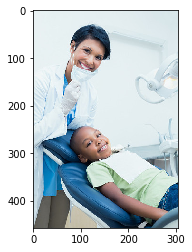

In [19]:
image_url = path.join(img_dir, 'train_00000006.jpg')
image = cv2.imread(image_url)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [25]:
for i in samples:
    if i['image_file'] == 'train_00000006.jpg':
        print(parse_labels(i['labels']))

[{'face': [79, 73, 71, 71], 'eyes': [112, 84, 138, 101], 'occlude': {'location': [4, 44, 54, 69], 'type': 1, 'degree': 1}, 'gender': 2, 'race': 3, 'orientation': 3, 'glass': [-1, -1, -1, -1]}]


In [74]:
# there are 2813 faces smaller than 30*30 which is hard to be used in the next step 
print(total_count)
print(small_face)
print(count_bare_face)

25876
2813
2


(0, 100)

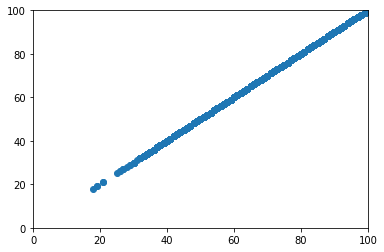

In [73]:
# all face boundary boxes are squares
plt.scatter(width, height)
plt.xlim(0,100)
plt.ylim(0,100)

In [47]:
total_count

25876

In [51]:
img_dir = 'train images/'
image_url = path.join(img_dir, sample['image_file'])
image = cv2.imread(image_url)

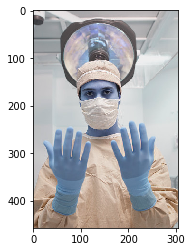

In [52]:
plt.imshow(image)

# augment

don't know why it doesn't work

In [39]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# os.chdir("../")

In [49]:
def augment(img, path, file):
    flip = tf.image.flip_left_right(img)
    gray = tf.image.rgb_to_grayscale(img)
    red = tf.image.adjust_hue(img,0.9)
    green = tf.image.adjust_hue(img, 0.3)
    yellow = tf.image.adjust_hue(img, 0.1)
    flip_gray = tf.image.rgb_to_grayscale(flip)
    flip_red = tf.image.adjust_hue(flip,0.9)
    flip_green = tf.image.adjust_hue(flip,0.3)
    flip_yellow = tf.image.adjust_hue(flip,0.1)
    au_img = [flip, gray, red, green, yellow, flip_gray, flip_red, flip_green, flip_yellow]
    au_name = ["flip", "gray", "red", "green", "yellow", "flip_gray", "flip_red", "flip_green",
               "flip_yellow"]
    for idx, image in enumerate(au_img):
        tf.keras.preprocessing.image.save_img(path + file + "_%s.jpg"%au_name[idx], image, data_format= "channels_last")  

In [50]:
folder = "data/MAFA/train_hb/"
files = os.listdir(folder + "test/")
for i in tqdm(files):
    path = folder + "test/" 
    for f in files:
        img = cv.imread(path + f)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

        augment(img, path, f)

  0%|          | 0/5 [00:00<?, ?it/s]

Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.map(tf.read_file)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


  0%|          | 0/5 [00:00<?, ?it/s]


ValueError: setting an array element with a sequence.

In [51]:
folder = "data/MAFA/train_hb/"
files = os.listdir(folder + "test/")
files

['train_00000004-0.jpg',
 'train_00000002-0.jpg',
 'train_00000005-0.jpg',
 'train_00000001-0.jpg',
 'train_00000003-0.jpg']

ValueError: Cannot evaluate tensor using `eval()`: No default session is registered. Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`

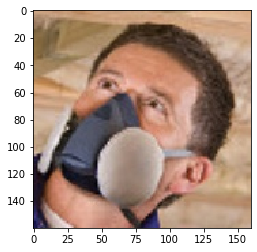

In [48]:
path = folder + "test/" 
for f in files:
    img = cv.imread(path + f)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    flip = tf.image.flip_left_right(img)
    plt.imshow(img)
    plt.imshow(flip)
    break

In [52]:
img.shape

(160, 160, 3)